## 0B - Multi-dimensional posteriors

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 27 April 2023

**Purpose**: We discuss how 2-dimensional (or higher) posteriors are trained and visualized.

**Key take-away messages**: Understand the meaning of `swyft.LogRatioEstimator_1dim` and `swyft.LogRatioEstimator_Ndim` arguments, `num_features`, `num_params`, and `marginals`.

### Code

In [15]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft

Let's consider an example with 3 model parameters $\mathbf{z}$

$$
x = (z[0]^2 + z[1]^2 + 0.5*z[0]*z[1]*z[2])^{1/2} + \epsilon
$$

where $z[i]$ have a Uniform prior $z[i] \sim \mathcal{U}(-1, 1)$ and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the 1d and 2d posteriors for parameters $\mathbf{z}$ given a measurement of parameter $x$.

In [16]:
N = 10000  # Number of samples
z = np.random.rand(N, 3)*2 - 1
r = (z[:,0]**2 + z[:,1]**2 + 0.5*z[:, 0]*z[:,1]*z[:,2])**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.1
samples = swyft.Samples(x = x, z = z)

Let us visualize some data.

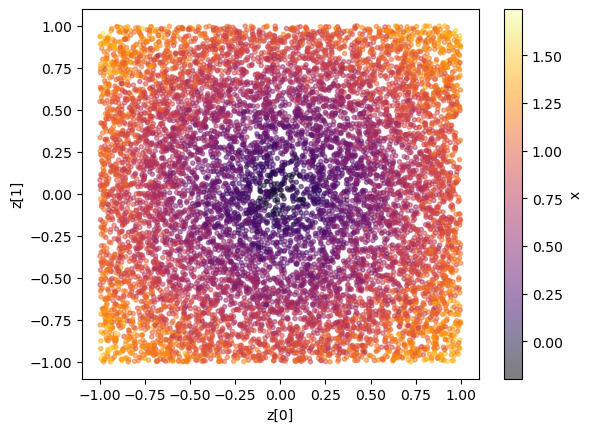

In [17]:
plt.scatter(z[:,0], z[:,1], c=x[:,0], marker='.', alpha = 0.5, cmap = 'inferno'); plt.xlabel("z[0]"); plt.ylabel("z[1]"); plt.colorbar(label = 'x');

Again, we could also take a look at the joint and marginal samples to get a feeling for the classification that will happen (although in the multidimensional example, it does not guarantee constraining power in the 1d marginals as there could be degeneracies). We can compare this to the results below to sanity check e.g. the sensitvity.

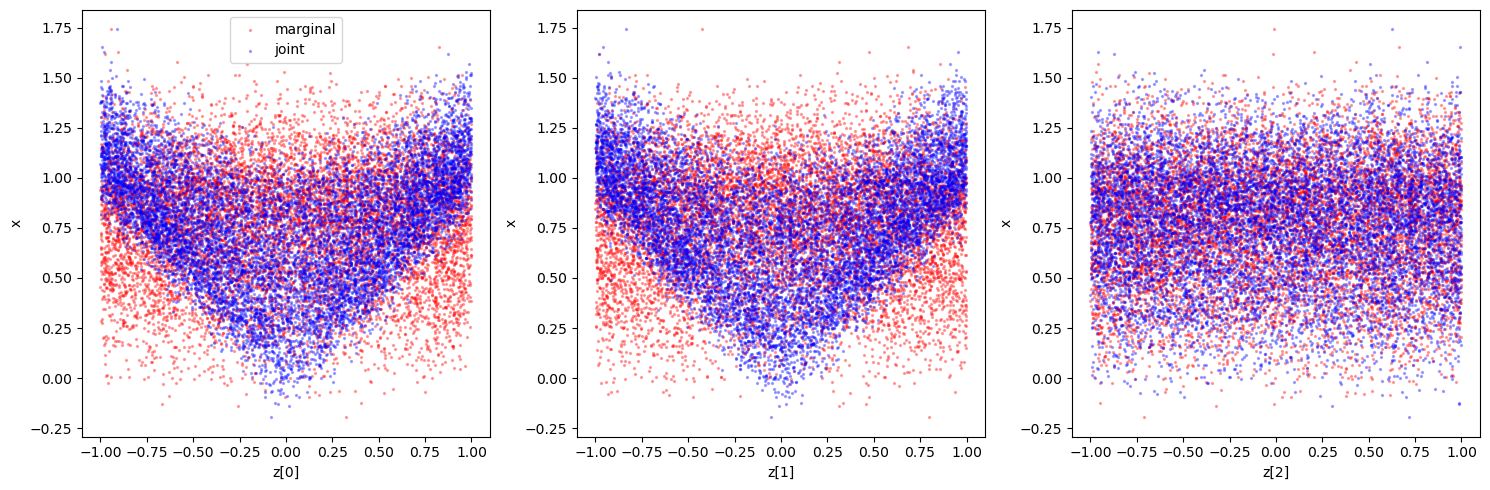

In [18]:
idx_arr = np.linspace(0, len(z) - 1, len(z), dtype=np.int32)
np.random.shuffle(idx_arr)
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
plt.scatter(z[idx_arr, 0], x[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(z[:, 0], x[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel('z[0]')
plt.ylabel('x')
plt.legend()
ax = plt.subplot(1, 3, 2)
plt.scatter(z[idx_arr, 1], x[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(z[:, 1], x[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel('z[1]')
plt.ylabel('x')
ax = plt.subplot(1, 3, 3)
plt.scatter(z[idx_arr, 2], x[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(z[:, 2], x[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel('z[2]')
plt.ylabel('x')
plt.tight_layout()

In this example we use Swyft default networks. 
- The first network, as seen in the previous example, is `swyft.LogRatioEstimator_1dim` that we use to estimate one-dimensional posteriors. In the present example, we set the length of the parameter vector (`num_params`) to 3, since we are interested in the three 1d posteriors for each of the $\mathbf{z}$ parameters, and data vectors (`num_features`) to one, since we pass the ratio estimator $x$.
- The second network is `swyft.LogRatioEstimator_Ndim`, a dense network for estimating multi-dimensional posteriors. In particular, in the present example we are interested in the estimating the 2d marginal posterior between parameters $z[0]$ and $z[1]$ (`marginals=((0, 1),)`) given the data point $x$ (`num_features=1`).

In [19]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        marginals = ((0, 1),)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 1, marginals = marginals, varnames = 'z')

    def forward(self, A, B):
        logratios1 = self.logratios1(A['x'], B['z'])
        logratios2 = self.logratios2(A['x'], B['z'])
        return logratios1, logratios2

Inference is the essentially done as described in Chapter A.

In [20]:
trainer = swyft.SwyftTrainer(accelerator = 'gpu', devices=1, max_epochs = 3, precision = 64)
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.2, 0.0])
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /gpfs/home2/weniger/swyft/notebooks/lightning_logs/version_2660707/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | logra

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [21]:
x0 = 0.5
obs = swyft.Sample(x = np.array([x0]))
prior_samples = swyft.Samples(z = np.random.rand(1_000_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 250it [00:00, ?it/s]

Text(0, 0.5, 'z[1]')

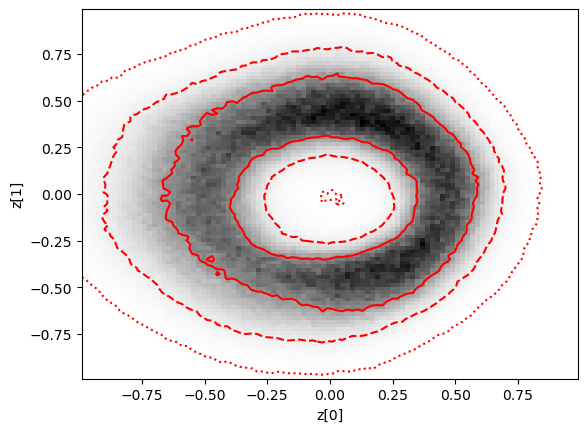

In [22]:
swyft.plot_2d(predictions, "z[0]", "z[1]", bins = 100, smooth = 0.5, color = 'r', ax = plt.gca(), cmap = 'gray_r');
plt.xlabel('z[0]')
plt.ylabel('z[1]')

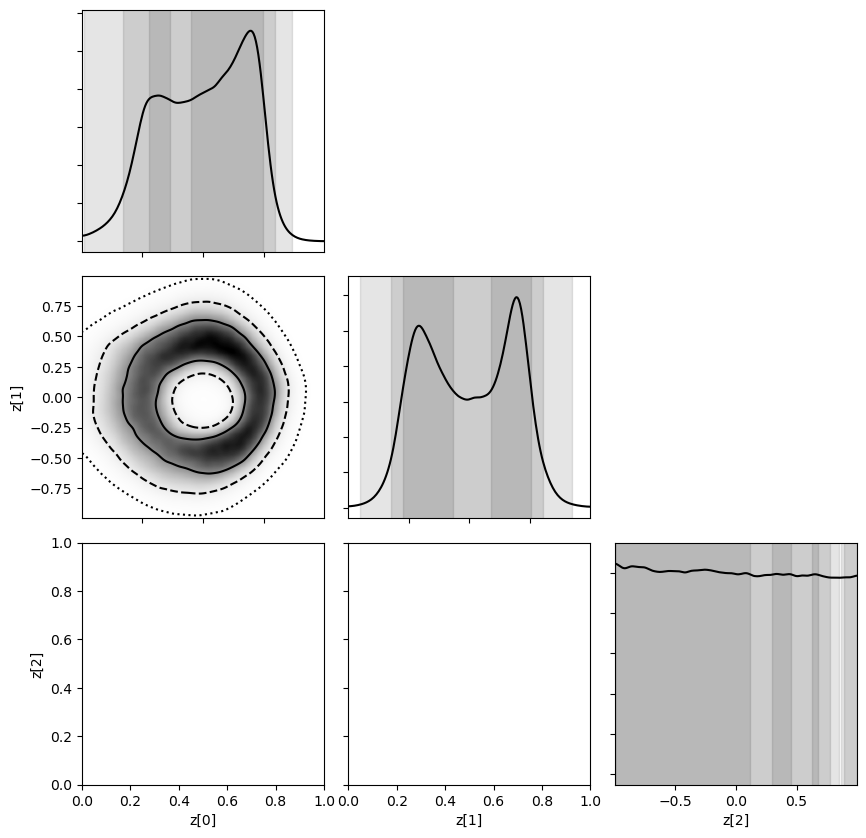

In [23]:
swyft.corner(predictions, ('z[0]', 'z[1]', 'z[2]'), bins = 200, smooth = 3);

### Exercises


1. Extract information from `predictions`. What lenght is it? What types of `LogRatioSamples` does it contain? What is the shape of `logratios` and `params`?

In [24]:
# Results go here

2. Provide only partial information when making inference plot.

In [25]:
# Results go here

3. Extend above example to estimate all marginal posteriors.

In [26]:
# Results go here